In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F


from functools import reduce
from pyspark.sql import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
spark = SparkSession.builder.appName('ChicagoTaxi').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.kryoserializer.buffer.max', '2000M'),
 ('spark.yarn.historyServer.address', 'btproject-m:18080'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'btproject-m'),
 ('spark.driver.maxResultSize', '0'),
 ('spark.yarn.unmanagedAM.enabled', 'true'),
 ('spark.sql.autoBroadcastJoinThreshold', '43m'),
 ('spark.ui.filters',
  'org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter'),
 ('spark.repl.local.jars',
  'file:///root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-3.3.4.jar,file:///root/.ivy2/jars/com.typesafe_config-1.4.1.jar,file:///root/.ivy2/jars/org.rocksdb_rocksdbjni-6.5.3.jar,file:///root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.603.jar,file:///root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,file:///root/.ivy2/jars/com.navigamez_greex-1.0.jar,

In [3]:
spark

## Load Data

In [4]:
df_2018 = spark.read.csv("gs://big_data_taxi/taxi-data/taxi_2018.csv", inferSchema=True, header=True)

In [5]:
df_2019 = spark.read.csv("gs://big_data_taxi/taxi-data/taxi_2019.csv", inferSchema=True, header=True)
df_2020 = spark.read.csv("gs://big_data_taxi/taxi-data/taxi_2020.csv", inferSchema=True, header=True)
df_2021 = spark.read.csv("gs://big_data_taxi/taxi-data/taxi_2021.csv", inferSchema=True, header=True)
df_2022 = spark.read.csv("gs://big_data_taxi/taxi-data/taxi_2022.csv", inferSchema=True, header=True)

In [6]:
# create list of dataframes
dfs = [df_2018, df_2019, df_2020,df_2021,df_2022]

# create merged dataframe
df_taxi = reduce(DataFrame.unionAll, dfs)

In [7]:
df_taxi.show(5, vertical=True)

-RECORD 0------------------------------------------
 Trip ID                    | fe928266cfcb233dd... 
 Taxi ID                    | 8b5e321e89ba9e3ea... 
 Trip Start Timestamp       | 01/01/2018 12:00:... 
 Trip End Timestamp         | 01/01/2018 12:00:... 
 Trip Seconds               | 0                    
 Trip Miles                 | 0.0                  
 Pickup Census Tract        | null                 
 Dropoff Census Tract       | null                 
 Pickup Community Area      | null                 
 Dropoff Community Area     | null                 
 Fare                       | 12.0                 
 Tips                       | 3.0                  
 Tolls                      | 0.0                  
 Extras                     | 0.0                  
 Trip Total                 | 15.0                 
 Payment Type               | Credit Card          
 Company                    | Suburban Dispatch... 
 Pickup Centroid Latitude   | null                 
 Pickup Cent

In [8]:
#shape 
print((df_taxi.count(), len(df_taxi.columns)))

(46759676, 23)


In [9]:
#Show schema of dataframe
df_taxi.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid 

In [10]:
#shape 
print((df_taxi.count(), len(df_taxi.columns)))

(46759676, 23)


In [11]:
#describe df
df_taxi.describe().show(vertical=True)

-RECORD 0------------------------------------------
 summary                    | count                
 Trip ID                    | 46759676             
 Taxi ID                    | 46759676             
 Trip Start Timestamp       | 46759676             
 Trip End Timestamp         | 46757402             
 Trip Seconds               | 46750901             
 Trip Miles                 | 46757852             
 Pickup Census Tract        | 28726861             
 Dropoff Census Tract       | 28521684             
 Pickup Community Area      | 43368840             
 Dropoff Community Area     | 42203931             
 Fare                       | 46755243             
 Tips                       | 46755243             
 Tolls                      | 42296339             
 Extras                     | 46755243             
 Trip Total                 | 46755243             
 Payment Type               | 46759676             
 Company                    | 46759676             
 Pickup Cent

In [12]:
#Find the number of missing values for each column
from pyspark.sql.functions import isnan, when, count, col
df_taxi.select([count(when(df_taxi[c].isNull(), c)).alias(c) for c in df_taxi.columns]).show(vertical=True)

-RECORD 0------------------------------
 Trip ID                    | 0        
 Taxi ID                    | 0        
 Trip Start Timestamp       | 0        
 Trip End Timestamp         | 2274     
 Trip Seconds               | 8775     
 Trip Miles                 | 1824     
 Pickup Census Tract        | 18032815 
 Dropoff Census Tract       | 18237992 
 Pickup Community Area      | 3390836  
 Dropoff Community Area     | 4555745  
 Fare                       | 4433     
 Tips                       | 4433     
 Tolls                      | 4463337  
 Extras                     | 4433     
 Trip Total                 | 4433     
 Payment Type               | 0        
 Company                    | 0        
 Pickup Centroid Latitude   | 3381359  
 Pickup Centroid Longitude  | 3381359  
 Pickup Centroid Location   | 3381359  
 Dropoff Centroid Latitude  | 4397653  
 Dropoff Centroid Longitude | 4397653  
 Dropoff Centroid  Location | 4397653  



In [13]:
#reformat timestamp
from pyspark.sql.functions import *
df_taxi = df_taxi.withColumn("Trip Start Timestamp",to_timestamp("Trip Start Timestamp","MM/dd/yyyy hh:mm:ss a"))
df_taxi  = df_taxi.withColumn("Trip End Timestamp",to_timestamp("Trip End Timestamp","MM/dd/yyyy hh:mm:ss a"))

In [14]:
#add trip date, day of week, hour
df_taxi = df_taxi.withColumn("trip_date",to_date(col("Trip Start Timestamp"), "yyyy-MM-dd HH:mm:ss" )).withColumn('day_of_week', date_format("Trip Start Timestamp", 'EEEE')).withColumn('hour', date_format("Trip Start Timestamp", 'HH'))

In [15]:
#cast hour as integer
from pyspark.sql.types import IntegerType
df_taxi = df_taxi.withColumn("hour", df_taxi["hour"].cast(IntegerType()))

In [16]:
#aggregate based on time
df_time =df_taxi.select('Trip ID', 'Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds', 'Trip Miles', 'Fare' )

In [17]:
#format timestamp
from pyspark.sql.functions import *
df_time = df_time.withColumn("Trip Start Timestamp",to_timestamp("Trip Start Timestamp","MM/dd/yyyy hh:mm:ss a"))
df_time = df_time.withColumn("Trip End Timestamp",to_timestamp("Trip End Timestamp","MM/dd/yyyy hh:mm:ss a"))

In [18]:
#add date and day of week
df_time = df_time.withColumn("trip_date",to_date(col("Trip Start Timestamp"), "yyyy-MM-dd HH:mm:ss" )).withColumn('day_of_week', date_format("Trip Start Timestamp", 'EEEE'))

In [19]:
#add hour column in df_time
df_time = df_time.withColumn('hour', date_format("Trip Start Timestamp", 'HH'))

In [20]:
#add trip minutes
df_time = df_time.withColumn("trip_minutes", col("Trip Seconds")/60)

In [21]:
#plot daily trip
daily_trip = df_time.groupBy(col("trip_date")).count().withColumnRenamed("count", "trips")

In [22]:
daily_trip.show(5)

+----------+-----+
| trip_date|trips|
+----------+-----+
|2019-01-07|40534|
|2019-01-08|42990|
|2019-03-14|61259|
|2019-03-17|35302|
|2019-10-05|33872|
+----------+-----+
only showing top 5 rows



## EDA

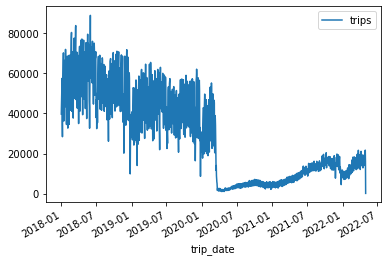

In [23]:
#Plot Daily Trips
import matplotlib.pyplot as plt
import pandas as pd 

pdf = daily_trip.toPandas()
pdf = pdf.set_index(pd.to_datetime(pdf['trip_date']))
pdf.plot()
plt.show()

In [24]:
#year month plot
df_time = df_time.withColumn('year-month', date_format('trip_date', 'yyyy-MM'))

In [25]:
trip_ym = df_time.groupBy(col("year-month")).count().withColumnRenamed("count", "trips")

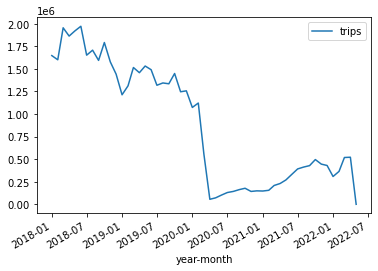

In [26]:
pdf = trip_ym.toPandas()
pdf = pdf.set_index(pd.to_datetime(pdf['year-month']))
pdf.plot()
plt.show()

Sudden decline in early 2020,  due to COVID, gradually increasing again but the numbers are not as high as before COVID

<AxesSubplot:xlabel='month'>

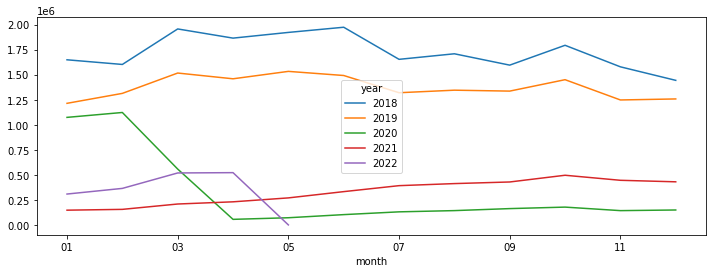

In [27]:
#yoy
df_time = df_time.withColumn('year', date_format('trip_date', 'yyyy')).withColumn('month', date_format('trip_date', 'MM'))
yoy_trip  = df_time.groupBy('year', 'month').count().orderBy(["year", "month"], ascending=[0, 0])
pdf = yoy_trip.toPandas()
pdf = pdf.pivot(index='month', columns='year', values='count')
pdf.plot(figsize=(12,4))

Taxi trips declined in 2020, increased in 2021 and 2022, still not the same level as 2018,2019

In [28]:
trip_minutes_daily = df_time.groupBy("trip_date").mean("trip_minutes").withColumnRenamed("avg(trip_minutes)", "avg_minutes")

In [29]:
trip_minutes_daily.show(5)

+----------+------------------+
| trip_date|       avg_minutes|
+----------+------------------+
|2018-04-18|15.520073270037148|
|2018-07-28| 14.18145250742345|
|2018-10-05|16.431242454424723|
|2019-05-08| 16.02933824604495|
|2020-08-24|16.601458789204962|
+----------+------------------+
only showing top 5 rows



In [30]:
trip_minutes_daily.select(mean(col('avg_minutes'))).show()

+------------------+
|  avg(avg_minutes)|
+------------------+
|16.200004728557406|
+------------------+



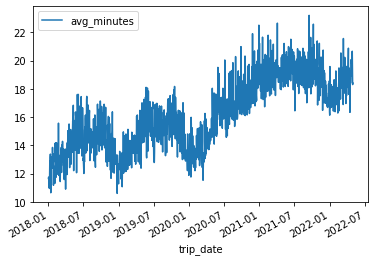

In [31]:
pdf = trip_minutes_daily.toPandas()
pdf = pdf.set_index(pd.to_datetime(pdf['trip_date']))
pdf.plot()
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In 2018-2020, avg trip minutes per day is around 10-16 minutes, increased in 2021 to around 16-20 minutes

In [32]:
trip_miles_daily = df_time.groupBy("trip_date").mean("Trip Miles").withColumnRenamed("avg(Trip Miles)", "avg_miles")

In [33]:
trip_miles_daily.show(5)

+----------+------------------+
| trip_date|         avg_miles|
+----------+------------------+
|2018-05-26|3.1401922618403053|
|2018-08-11|3.2073062307738756|
|2018-11-02| 3.154027203028325|
|2018-11-01|3.4728913150733867|
|2019-02-23| 3.036457802682995|
+----------+------------------+
only showing top 5 rows



In [34]:
trip_miles_daily.select(mean(col('avg_miles'))).show()

+-----------------+
|   avg(avg_miles)|
+-----------------+
|4.430777416411717|
+-----------------+



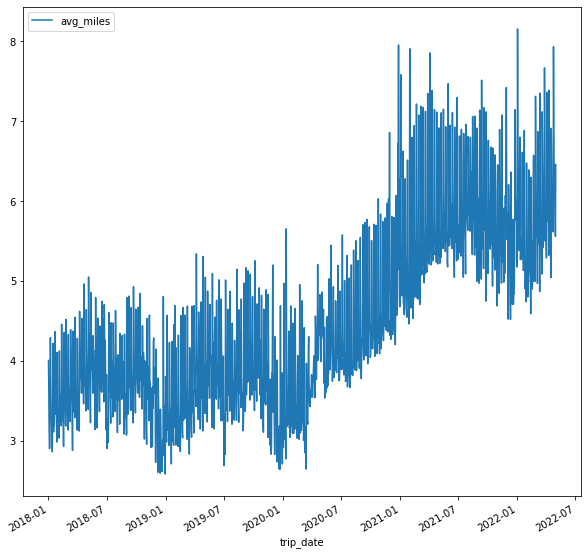

In [35]:
pdf = trip_miles_daily.toPandas()
pdf = pdf.set_index(pd.to_datetime(pdf['trip_date']))
pdf.plot()
plt.rcParams["figure.figsize"] = (20,30)
plt.show()

In 2018-2020, avg miles: 3-5, increased since 2021 to around 5-7 miles per day

In [36]:
#trip day of week
dow_trip = df_time.groupBy(col("day_of_week")).count().withColumnRenamed("count", "trips").orderBy("count", ascending=False)

In [37]:
dow_trip.show(5)

+-----------+-------+
|day_of_week|  trips|
+-----------+-------+
|     Friday|7796659|
|   Thursday|7758637|
|  Wednesday|7330901|
|    Tuesday|7135031|
|     Monday|6516227|
+-----------+-------+
only showing top 5 rows



<AxesSubplot:xlabel='day_of_week'>

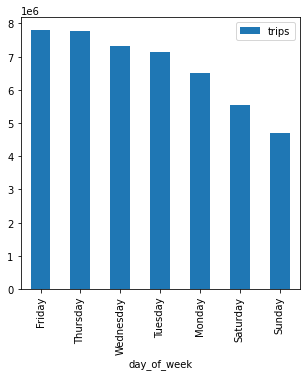

In [38]:
#plot horizontal barchart
pdf = dow_trip.toPandas()
plt.rcParams["figure.figsize"] = (5,5)
pdf.plot(kind= 'bar', y='trips', x='day_of_week')

Most trips happen on Friday and Thursday

In [39]:
#minutes per day
dow_trip_duration = df_time.groupBy(col("day_of_week")).mean("trip_minutes").withColumnRenamed("avg(trip_minutes)", "avg_minutes").orderBy("avg_minutes", ascending=False)

In [40]:
dow_trip_duration.show(5)

+-----------+------------------+
|day_of_week|       avg_minutes|
+-----------+------------------+
|   Thursday|15.750693452944171|
|     Sunday|15.345142558053487|
|     Friday|15.271654122876107|
|  Wednesday|15.262516511711505|
|     Monday| 15.24276563967403|
+-----------+------------------+
only showing top 5 rows



<AxesSubplot:xlabel='day_of_week'>

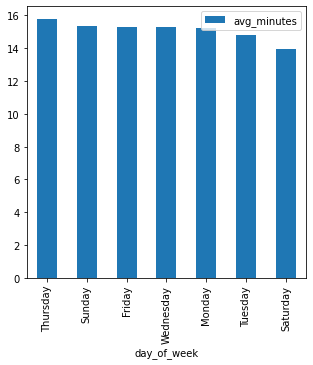

In [41]:
#plot horizontal barchart
pdf = dow_trip_duration.toPandas()
plt.rcParams["figure.figsize"] = (5,5)
pdf.plot(kind= 'bar', y='avg_minutes', x='day_of_week')

Longest trip --> Thursday, followed by other days but the difference isn't that significant

In [42]:
#plot hour
hour_trip = df_time.groupBy(col("hour")).count().withColumnRenamed("count", "trips").orderBy("count", ascending=False)

<AxesSubplot:xlabel='hour'>

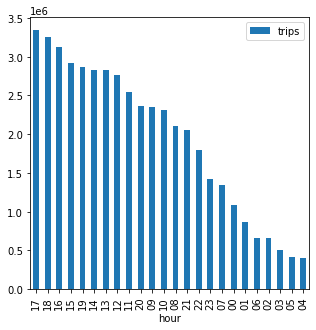

In [43]:
#plot horizontal barchart
pdf = hour_trip.toPandas()
plt.rcParams["figure.figsize"] = (5,5)
pdf.plot(kind= 'bar', y='trips', x='hour')

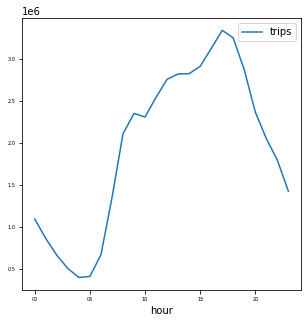

In [44]:
hour_trip = hour_trip.orderBy("hour", ascending=True)
pdf = hour_trip.toPandas()
x = pdf.hour
pdf.plot(x='hour', y='trips', sharex=False)
plt.rcParams["figure.figsize"] = (5,5)
plt.tick_params(axis='both', which='major', labelsize=5)
plt.xticks([0,5,10,15,20])
plt.show()

Most Trips happen at 16-18 pm

In [45]:
#minutes per hour
hour_trip_duration = df_time.groupBy(col("hour")).mean("trip_minutes").withColumnRenamed("avg(trip_minutes)", "avg_minutes").orderBy("avg_minutes", ascending=False)

In [46]:
hour_trip_duration.show(5)

+----+------------------+
|hour|       avg_minutes|
+----+------------------+
|  15|17.373721147762055|
|  17|17.303109410319642|
|  16| 17.23965176316731|
|  18|16.337830944026837|
|  06|16.278947760307222|
+----+------------------+
only showing top 5 rows



<AxesSubplot:xlabel='hour'>

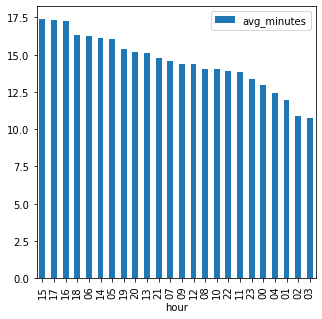

In [47]:
#plot horizontal barchart
pdf = hour_trip_duration.toPandas()
plt.rcParams["figure.figsize"] = (5,5)
pdf.plot(kind= 'bar', y='avg_minutes', x='hour')

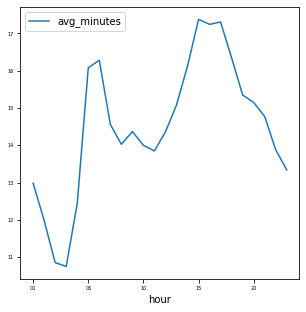

In [48]:
hour_trip_duration = hour_trip_duration.orderBy("hour", ascending=True)
pdf = hour_trip_duration.toPandas()
pdf.plot(x='hour', y='avg_minutes', sharex=False)
plt.rcParams["figure.figsize"] = (20,20)
plt.tick_params(axis='both', which='major', labelsize=5)
plt.xticks([0,5,10,15,20])
plt.show()

morning: longest trip at 06 AM, evening at 3 pm

Taxi demand prediction: https://sanjayc.medium.com/manhattan-taxi-demand-prediction-f16880d00fde
https://medium.com/swlh/machine-learning-and-cab-industry-64e8add3b8cd

### Modelling

In [49]:
#join with community df
df_communities = spark.read.csv('gs://big_data_taxi/taxi-data/community.csv', inferSchema=True, header=True)

df_taxi = df_taxi.join(df_communities, df_taxi['Pickup Community Area'] == df_communities['community_id'], 
                       "left_outer")

df_taxi = df_taxi.drop('community_id').withColumnRenamed('community_name','Pickup Community Name')

df_taxi = df_taxi.join(df_communities, df_taxi['Dropoff Community Area'] == df_communities['community_id'], 
                       "left_outer")

df_taxi = df_taxi.drop('community_id').withColumnRenamed('community_name','Dropoff Community Name')

In [50]:
#aggregation data for modelling
agg = df_taxi.groupBy('Trip Start Timestamp','trip_date','Pickup Community Area', 'day_of_week', 'hour').agg(sum('Trip Miles'),count('Trip ID'),sum('Trip Seconds'))

### Read Additional Data

In [51]:
# holiday
df_holiday = spark.read.csv("gs://big_data_taxi/taxi-data/us_holiday_dates.csv", inferSchema=True, header=True)

In [52]:
df_holiday.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Holiday: string (nullable = true)
 |-- WeekDay: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Year: integer (nullable = true)



In [53]:
#weather
df_weather1 = spark.read.csv("gs://big_data_taxi/taxi-data/chicago_weather_20182019.csv", inferSchema=True, header=True)
df_weather2 = spark.read.csv("gs://big_data_taxi/taxi-data/chicago_weather_20202021.csv", inferSchema=True, header=True)

In [54]:
# create list of dataframes
dfs = [df_weather1, df_weather2]

# create merged dataframe
df_weather = reduce(DataFrame.unionAll, dfs)

In [55]:
#filter weather for ohare international station
df_weather_chi = df_weather.filter(col('STATION')=='USW00094846')

In [56]:
#only add precipitation and snow
df_weather_chi = df_weather_chi.select(df_weather_chi["DATE"],df_weather_chi["PRCP"], df_weather_chi['SNOW'])

In [57]:
#check for null values
from pyspark.sql.functions import col,isnan, when, count
df_weather_chi.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_weather_chi.columns]
   ).show()

+----+----+----+
|DATE|PRCP|SNOW|
+----+----+----+
|   0|   0|   0|
+----+----+----+



## Feature Addition

In [58]:
#is weekend indicator
agg = agg.withColumn(
    'is_weekend',
    F.when((F.col("day_of_week") == 'Saturday') | (F.col("day_of_week") =='Sunday') , 1)\
    .otherwise(0))

In [59]:
#join with holiday
agg = agg.join(df_holiday, agg['trip_date'] == df_holiday['Date'], 
                       "left_outer")

In [60]:
#is holiday indicator
agg = agg.withColumn(
    'is_holiday',
    F.when(isnan('Holiday') | col('Holiday').isNull() , 0)\
    .otherwise(1))

In [61]:
#join with weather
agg = agg.join(df_weather_chi, agg['trip_date'] == df_weather_chi['DATE'], 
                       "left_outer")

In [62]:
#Extract year, month day of week number
agg = agg.withColumn('year',year('trip_date')).withColumn('month',month('trip_date')).withColumn('dow',dayofweek('trip_date')).withColumn('week',weekofyear('trip_date'))

In [63]:
#covid indicator
agg = agg.withColumn(
    'after_covid',
    F.when(col('trip_date')>'2019-12-31' , 1)\
    .otherwise(0))

In [64]:
#create model df 
df_model = agg.drop('Date','Holiday','WeekDay','Trip Start Timestamp','trip_date','day_of_week','Day','DATE')

In [65]:
df_model.printSchema()

root
 |-- Pickup Community Area: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- sum(Trip Miles): double (nullable = true)
 |-- count(Trip ID): long (nullable = false)
 |-- sum(Trip Seconds): long (nullable = true)
 |-- is_weekend: integer (nullable = false)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- is_holiday: integer (nullable = false)
 |-- PRCP: double (nullable = true)
 |-- SNOW: double (nullable = true)
 |-- dow: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- after_covid: integer (nullable = false)



In [66]:
df_model = df_model.withColumnRenamed('sum(Trip Miles)', 'trip_miles').withColumnRenamed('count(Trip ID)', 'trips').withColumnRenamed('sum(Trip Seconds)', 'trip_seconds')

## Handle Null Values

In [67]:
#Check for Null Values
df_model.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_model.columns]
   ).show()

+---------------------+----+----------+-----+------------+----------+-----+----+----------+------+------+---+----+-----------+
|Pickup Community Area|hour|trip_miles|trips|trip_seconds|is_weekend|month|year|is_holiday|  PRCP|  SNOW|dow|week|after_covid|
+---------------------+----+----------+-----+------------+----------+-----+----+----------+------+------+---+----+-----------+
|               143657|   0|        97|    0|         644|         0|    0|   0|         0|292890|292890|  0|   0|          0|
+---------------------+----+----------+-----+------------+----------+-----+----+----------+------+------+---+----+-----------+



In [68]:
#Remove Pickup Community Area 
df_model =  df_model.filter(col('Pickup Community Area'). isNotNull())

In [69]:
#Fill NA weather with 0
df_model = df_model.fillna(0, subset=['PRCP', 'SNOW'])

In [70]:
#remove all na values
df_model = df_model.dropna()

In [71]:
#Recheck
df_model.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_model.columns]
   ).show()

+---------------------+----+----------+-----+------------+----------+-----+----+----------+----+----+---+----+-----------+
|Pickup Community Area|hour|trip_miles|trips|trip_seconds|is_weekend|month|year|is_holiday|PRCP|SNOW|dow|week|after_covid|
+---------------------+----+----------+-----+------------+----------+-----+----+----------+----+----+---+----+-----------+
|                    0|   0|         0|    0|           0|         0|    0|   0|         0|   0|   0|  0|   0|          0|
+---------------------+----+----------+-----+------------+----------+-----+----+----------+----+----+---+----+-----------+



## Correlation between Variables

In [ ]:
pdf = df_model.toPandas()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#correlation matrix
cor = pdf.corr()

#Plotting heatmap
plt.figure(figsize=(20,10))
sns.heatmap(cor, annot=True)

## Model

In [ ]:
from pyspark import SparkFiles
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StringIndexer,OneHotEncoder, IndexToString, VectorAssembler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import FloatType
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
spark = SparkSession.builder.appName('Spark-Autos-Regression').getOrCreate()

In [ ]:
# Prepare the data by indexing the classes and putting the features into a vector.
vectorAssembler = VectorAssembler(inputCols=["year","month", "week", "dow","hour","Pickup Community Area",
                                              "is_weekend", "is_holiday", 'trip_seconds', "PRCP", "SNOW", "after_covid"],
                                  outputCol="features")


In [ ]:
df_model_2 = vectorAssembler.transform(df_model)

In [ ]:
# Split the data into training and test sets.
train_df, test_df =  df_model_2.randomSplit([0.8, 0.2],0.0)

In [ ]:
train_df.show(5)

+---------------------+----+----------+-----+------------+----------+-----+----+----------+----+----+---+----+-----------+--------------------+
|Pickup Community Area|hour|trip_miles|trips|trip_seconds|is_weekend|month|year|is_holiday|PRCP|SNOW|dow|week|after_covid|            features|
+---------------------+----+----------+-----+------------+----------+-----+----+----------+----+----+---+----+-----------+--------------------+
|                    1|   0|       0.0|    1|           0|         0|    3|2018|         0| 0.0| 0.0|  6|   9|          0|(12,[0,1,2,3,5],[...|
|                    1|   0|       0.0|    1|           0|         0|    3|2018|         0|0.07| 0.0|  3|  10|          0|(12,[0,1,2,3,5,9]...|
|                    1|   0|       0.0|    1|           0|         0|    3|2019|         0| 0.0| 0.0|  5|  10|          0|(12,[0,1,2,3,5],[...|
|                    1|   0|       0.0|    1|           0|         0|   11|2021|         0| 0.0| 0.0|  3|  44|          1|(12,[0,1,2,3,5

In [ ]:
#Baseline Model
from pyspark.ml.regression import LinearRegression

#Elastic Net
lr = LinearRegression(featuresCol = 'features', labelCol='trips', regParam=0.3, elasticNetParam=0.8, maxIter=10)
lrm = lr.fit(train_df)

#coefficients
print("Coefficients: " + str(lrm.coefficients))
print("Intercept: " + str(lrm.intercept))

#model summary
print("RMSE: %f" % lrm.summary.rootMeanSquaredError)
print("r2: %f" % lrm.summary.r2)

22/05/31 00:46:55 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/05/31 00:46:55 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Coefficients: [-0.34534440134749794,-0.022700557868773737,-0.008944715324804594,0.0,0.0,-0.17090153003873151,0.0,0.0,0.0010513101148750825,0.0,0.0,0.0]
Intercept: 703.7354949997554
RMSE: 17.716863
r2: 0.799867


In [ ]:
# Run the classifier on the test set
predictions = lrm.transform(test_df)
predictions.select('features','trips','prediction').show(5,truncate=False)

+---------------------------------------------------------+-----+-----------------+
|features                                                 |trips|prediction       |
+---------------------------------------------------------+-----+-----------------+
|[2020.0,7.0,29.0,2.0,0.0,1.0,0.0,0.0,480.0,0.0,0.0,1.0]  |1    |6.05523095341016 |
|[2019.0,10.0,44.0,5.0,0.0,1.0,0.0,0.0,780.0,0.31,3.4,0.0]|2    |6.51369598574172 |
|(12,[0,1,2,3,5,8],[2018.0,1.0,3.0,4.0,1.0,54.0])         |1    |6.666827592825939|
|(12,[0,1,2,3,5,8],[2018.0,1.0,4.0,5.0,1.0,95.0])         |1    |6.700986592210938|
|[2019.0,11.0,48.0,5.0,0.0,1.0,0.0,1.0,960.0,0.0,0.0,0.0] |3    |6.644452387251249|
+---------------------------------------------------------+-----+-----------------+
only showing top 5 rows



In [ ]:
#print evaluation metrics
e = RegressionEvaluator(labelCol="trips", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error
rmse = e.evaluate(predictions)
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = e.evaluate(predictions, {e.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = e.evaluate(predictions, {e.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = e.evaluate(predictions, {e.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 17.600


MSE: 309.754


MAE: 6.830


r2: 0.802


In [ ]:
#Random Forest
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(labelCol="trips", featuresCol="features", numTrees=2, maxDepth=3)
rfr  = rf.fit(train_df)

In [ ]:
predictions = rfr.transform(test_df)
predictions.select('features','trips','prediction').show(5,truncate=False)

+---------------------------------------------------------+-----+------------------+
|features                                                 |trips|prediction        |
+---------------------------------------------------------+-----+------------------+
|[2020.0,7.0,29.0,2.0,0.0,1.0,0.0,0.0,480.0,0.0,0.0,1.0]  |1    |5.1919202655711185|
|[2019.0,10.0,44.0,5.0,0.0,1.0,0.0,0.0,780.0,0.31,3.4,0.0]|2    |5.1919202655711185|
|(12,[0,1,2,3,5,8],[2018.0,1.0,3.0,4.0,1.0,54.0])         |1    |5.1919202655711185|
|(12,[0,1,2,3,5,8],[2018.0,1.0,4.0,5.0,1.0,95.0])         |1    |5.1919202655711185|
|[2019.0,11.0,48.0,5.0,0.0,1.0,0.0,1.0,960.0,0.0,0.0,0.0] |3    |5.1919202655711185|
+---------------------------------------------------------+-----+------------------+
only showing top 5 rows



In [ ]:
#print evaluation metrics
e = RegressionEvaluator(labelCol="trips", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error
rmse = e.evaluate(predictions)
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = e.evaluate(predictions, {e.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = e.evaluate(predictions, {e.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = e.evaluate(predictions, {e.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 17.106


MSE: 292.626


MAE: 6.690


r2: 0.813


In [ ]:
#Decision Tree Regressor
from  pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(labelCol="trips", featuresCol="features", maxDepth=3)
dtr  = dt.fit(train_df)

In [ ]:
predictions = dtr.transform(test_df)
predictions.select('features','trips','prediction').show(5,truncate=False)

+---------------------------------------------------------+-----+-----------------+
|features                                                 |trips|prediction       |
+---------------------------------------------------------+-----+-----------------+
|[2020.0,7.0,29.0,2.0,0.0,1.0,0.0,0.0,480.0,0.0,0.0,1.0]  |1    |2.153531165915741|
|[2019.0,10.0,44.0,5.0,0.0,1.0,0.0,0.0,780.0,0.31,3.4,0.0]|2    |2.153531165915741|
|(12,[0,1,2,3,5,8],[2018.0,1.0,3.0,4.0,1.0,54.0])         |1    |2.153531165915741|
|(12,[0,1,2,3,5,8],[2018.0,1.0,4.0,5.0,1.0,95.0])         |1    |2.153531165915741|
|[2019.0,11.0,48.0,5.0,0.0,1.0,0.0,1.0,960.0,0.0,0.0,0.0] |3    |2.153531165915741|
+---------------------------------------------------------+-----+-----------------+
only showing top 5 rows



In [ ]:
#print evaluation metrics
e = RegressionEvaluator(labelCol="trips", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error
rmse = e.evaluate(predictions)
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = e.evaluate(predictions, {e.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = e.evaluate(predictions, {e.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = e.evaluate(predictions, {e.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 14.405


MSE: 207.503


MAE: 4.664


r2: 0.867


In [ ]:
#Gradient Boosted Tree Regression
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(labelCol="trips", featuresCol="features", maxIter=10)
gbt_model = gbt.fit(train_df)

In [ ]:
predictions = gbt_model.transform(test_df)
predictions.select('features','trips','prediction').show(5,truncate=False)

+---------------------------------------------------------+-----+------------------+
|features                                                 |trips|prediction        |
+---------------------------------------------------------+-----+------------------+
|[2020.0,7.0,29.0,2.0,0.0,1.0,0.0,0.0,480.0,0.0,0.0,1.0]  |1    |1.8968492260581906|
|[2019.0,10.0,44.0,5.0,0.0,1.0,0.0,0.0,780.0,0.31,3.4,0.0]|2    |2.148460810192645 |
|(12,[0,1,2,3,5,8],[2018.0,1.0,3.0,4.0,1.0,54.0])         |1    |1.7973623028041865|
|(12,[0,1,2,3,5,8],[2018.0,1.0,4.0,5.0,1.0,95.0])         |1    |1.7973623028041865|
|[2019.0,11.0,48.0,5.0,0.0,1.0,0.0,1.0,960.0,0.0,0.0,0.0] |3    |2.148460810192645 |
+---------------------------------------------------------+-----+------------------+
only showing top 5 rows



In [ ]:
#print evaluation metrics
e = RegressionEvaluator(labelCol="trips", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error
rmse = e.evaluate(predictions)
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = e.evaluate(predictions, {e.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = e.evaluate(predictions, {e.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = e.evaluate(predictions, {e.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 9.887


MSE: 97.760


MAE: 2.983


r2: 0.937


##  Plot Chosen Model

In [ ]:
pred_pd = predictions.toPandas()

In [ ]:
pred_pd.tail()

,Pickup Community Area,hour,trip_miles,trips,trip_seconds,is_weekend,month,year,is_holiday,PRCP,SNOW,dow,week,after_covid,features,prediction
705499,77,23,8.40,4,2234,0,2,2018,0,0.57,6.2,6,6,0,"[2018.0, 2.0, 6.0, 6.0, 23.0, 77.0, 0.0, 0.0, ...",3.692161
705500,77,23,8.70,4,2059,0,8,2018,0,0.00,0.0,2,35,0,"[2018.0, 8.0, 35.0, 2.0, 23.0, 77.0, 0.0, 0.0,...",3.710667
705501,77,23,10.79,5,2352,1,7,2018,0,0.07,0.0,1,30,0,"[2018.0, 7.0, 30.0, 1.0, 23.0, 77.0, 1.0, 0.0,...",3.710667
705502,77,23,14.54,9,6336,0,3,2019,0,0.00,0.0,6,9,0,"[2019.0, 3.0, 9.0, 6.0, 23.0, 77.0, 0.0, 0.0, ...",6.618818
705503,77,23,15.00,6,3721,0,1,2018,0,0.36,0.0,5,2,0,"[2018.0, 1.0, 2.0, 5.0, 23.0, 77.0, 0.0, 0.0, ...",5.455098


Text(0, 0.5, 'Predictions ')

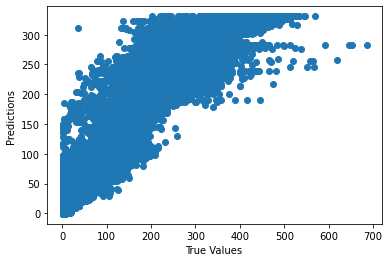

In [97]:
g=plt.scatter(pred_pd['trips'], pred_pd['prediction'])
g.axes.set_xlabel('True Values ')
g.axes.set_ylabel('Predictions ')
